In [9]:
import matplotlib.pyplot as plt
import matplotlib
import scipy
import numpy as np
import pandas as pd
import statsmodels
import seaborn as sns
import math

#matplotlib inline

**Tvjens**:
    Below my suggestion for a program structure which should allow easy extensions and simplify monte carlo simulation.
   
One starts by defining combinations of:
- Demand time series (Demand of the underlying device w/o duty cycle distortion or noise)
- Ground truth parameters (Describes how the underlying demand may be shifted in time due to duty cycle distortions or have some additional noise on the signal itself)
- Measurement device parameters (Describes how the bias and noise of the measurement device affect the measured result)

Then, these combinations are passed to a World, which builds lists of devices and ground truths.
One can query the World for measurements and ground truths to evaluate the impact of measurement.
The World also handles stepping to the next time step.

Each ground truth consists of an underlying demand time series which is shifted + noised by certain parameters.

Each measurement device distorts the ground truth according to distributions defined by their parameters.

See the block below the classes for example usage. (The current implementation does not distort or randomize.)

In [3]:
class GenerateTruthAndDevice:
    '''
        Allows drawing combinations of demand time series and measurement devices.
        For now, demand signals and ground truth should be drawn independently.
        
        FUTURE: Allows associating certain devices with certain types of load,
        e.g. partial rollout of high quality devices to some residential consumers
        or industrial consumers having better devices etc.
    '''
    def __init__(self):
        #TODO: Build me.
        pass
    
    def get_parameter_set(self):
        '''
            Returns combinations of demand time series, truth parameters, and
            measurement device parameters
        '''
        #TODO: Add random drawing from pool.
        demand_ts = [[0,5],[10,6]] # list of (time,demand) pairs, ordered by time
        truth_parameters = {} # Dict of attributes for a ground truth
        device_parameters = {} # Dict of attributes for a device
        return demand_ts, truth_parameters, device_parameters
        
    pass

In [4]:
class World:
    '''
        Facilitates measurement from a pool of devices + associated ground truths.
        Handles time progression and data collection.
    '''
    
    def __init__(
        self, sim_horizon=10, step_size=1, pool_size=10, 
        param_generator=GenerateTruthAndDevice()):
        
        # Save simulation parameters
        self.sim_horizon = sim_horizon
        self.step_size = step_size
        self.pool_size = pool_size
        self.cur_time = 0
        
        # Add lists for devices and truths, populate them
        self.param_generator = param_generator
        self.device_list, self.truth_list = [], []
        self.populate_device_and_truth_lists()
        pass
    
    def populate_device_and_truth_lists(self):
        # TODO: Logic to handle extending the pool of devices?
        num_missing = self.pool_size
        for _ in range(num_missing):
            demand_ts, truth_params, device_params = self.param_generator.get_parameter_set()
            ground_truth = GroundTruth(demand_ts=demand_ts, truth_params=truth_params)
            measurement_device = MeasurementDevice(ground_truth=ground_truth, device_params=device_params)
            self.truth_list.append(ground_truth)
            self.device_list.append(measurement_device)
    
    def get_measurements(self):
        measurements = list(md.get_measurement() for md in self.device_list)
        return measurements
    
    def get_sum_measurement(self):
        return sum(self.get_measurements())
    
    def get_ground_truths(self):
        ground_truths = list(gt.get_truth() for gt in self.truth_list)
        return ground_truths
    
    def get_sum_ground_truths(self):
        return sum(self.get_ground_truths())
    
    def step_time(self):
        '''Step all ground truths to next timestep'''
        self.cur_time = self.cur_time + self.step_size
        (gt.advance_time(self.cur_time) for gt in self.truth_list)
        pass

In [5]:
class GroundTruth:
    '''Holds the underlying truth which measurement devices report on
    Contains: Capacity, duty cycle etc. of device being measured.
    Also allows for time progressing - should hold an array for the underlying demand
    '''
    def __init__(self, demand_ts=[[0, 5], [10, 6]], truth_params={}):
        self.demand_ts = demand_ts
        self.params = truth_params
        self.advance_time(0)
    
    def _populate_duty_cycle_parameters(self):
        #TODO: Add generators for duty cycle parameters
        pass
    
    def get_truth(self):
        return self.cur_demand
    
    def advance_time(self, cur_time):
        #TODO: Interpolate for cur_time based on demand_ts
        #TODO: Add duty cycle offsets in here
        self.cur_demand = self.demand_ts[0][1]
        self.cur_time = cur_time

In [28]:
class MeasurementDevice:
    '''
        Reads from the ground truth and distorts it according to drift, bias etc.
        Contains: Prop_bias, Prop_noise_var, Zero_drift, Zero_noise_var, Quantization.    
    ''' 
    def __init__(self, ground_truth, device_params={}):
        self.device_params = device_params
        self.ground_truth=ground_truth
        self._populate_distortion_pdfs()
    
    def _populate_distortion_pdfs(self):
        '''
            Using self.device_params, build the pdfs that we draw from to get our distortion,
            and extract quantization parameter
        '''
        pass
    
    def get_measurement(self):
        #TODO: add proper distortion and quantization
        return self.ground_truth.get_truth() + np.random.normal()

(90, 110)

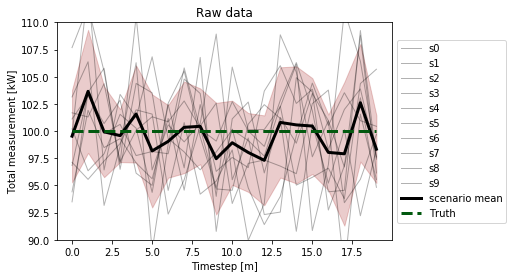

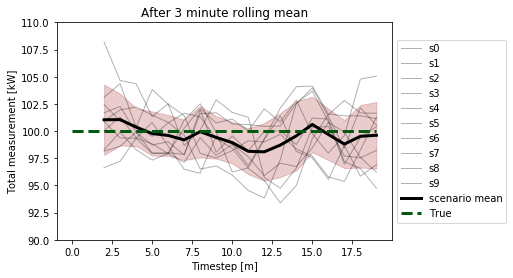

In [44]:
# Add your preferred sets here!
param_generator = GenerateTruthAndDevice()

# Build a world that we can measure from
world = World(pool_size=20, sim_horizon=20, param_generator=param_generator)

# We're looking to run 10 scenarios
NUM_SCENARIOS=10
scenarios = ['s{0}'.format(s) for s in range(NUM_SCENARIOS)]
data = {s:[] for s in scenarios}
truth = []
timesteps = []

# Simulate and collect data
while world.cur_time < world.sim_horizon:
    timesteps.append(world.cur_time)
    for s,l in data.items():
        l.append(world.get_sum_measurement())
    truth.append(world.get_sum_ground_truths())
    world.step_time()

df = pd.DataFrame(index=timesteps, data=data)
tdf = pd.Series(index=timesteps, data=truth)

# Plot results
fig = plt.figure()
ax = plt.axes()
plt.title('Raw data')
ma, mstd = df.mean(axis=1), df.std(axis=1)

df.plot(c='k',lw=1, ax=ax, alpha=0.3)
ma.plot(c='k',lw=3, ax=ax, label='scenario mean')
ax.fill_between(mstd.index, ma-mstd, ma+mstd, color=sns.xkcd_rgb['deep red'], alpha=0.2)
tdf.plot(c=sns.xkcd_rgb['deep green'], ls='--', lw=3, label='Truth', ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Timestep [m]')
plt.ylabel('Total measurement [kW]')
plt.ylim([90, 110])

fig2 = plt.figure()
rax = plt.axes()
plt.title('After 3 minute rolling mean')
rdf = df.rolling(3).mean()
rma, rmstd = rdf.mean(axis=1), rdf.std(axis=1)

rdf.plot(c='k',lw=1, ax=rax, alpha=0.3)
rma.plot(c='k',lw=3, ax=rax, label='scenario mean')
rax.fill_between(rmstd.index, rma-rmstd, rma+rmstd, color=sns.xkcd_rgb['deep red'], alpha=0.2)
tdf.plot(c=sns.xkcd_rgb['deep green'], ls='--', lw=3, label='True', ax=rax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Timestep [m]')
plt.ylabel('Total measurement [kW]')
plt.ylim([90, 110])


----

### Some Comments: 
- The impact on the error of a **_single_** measurement between the types of error we describe (Bias vs. Noise) is indecipherable.  In order to determine the impact of each we must assign measurement error parameters and take repeated measurement snapshots with the same resource to look at the distribution of errors.  
- If we draw bias from a random distribution, then in aggregate, we don't expect it to look any different than noise unless we give it a non-zero distribution, and I suppose it could be drawn from a non-normal distribution.  
- Define meter classes such that the total error is inside the accuracy of the class
- The error  

## Scenario analysis on the error parameters
- Generate random resoure: n = 10, 50, 100, 1000, 10000
- The zero-point drift and Constant Noise need to be relative to some quantity.  We will assume that all meters are 200A class, and that service voltage is 240V, single phase.  So the total quantity of constant error will be relative to 48kW.  This seems reasonable, as the amperage class of the meter will be based on the main breaker of a residential service panel, and homes with HVAC units are more likely to have a 200A panel than a 100A panel.  